<a href="https://colab.research.google.com/github/flaviorosso/market-breadth-analysis/blob/main/Market_Breadth_Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Introduction***

Financial markets are fundamentally driven by human emotions, particularly greed and fear. When a large majority of assets—***around 90%***—are trading ***above*** their ***moving averages***, it often signals that the crowd is overly optimistic, believing in endless gains. Historically, such extreme optimism tends to appear near market tops. Conversely, when ***about 90%*** of assets are trading ***below*** their ***moving averages***, it reflects widespread pessimism. This exaggerated fear can often coincide with market bottoms, presenting potential opportunities for recovery.

This notebook was developed to analyze ***Market Breadth***, aiming to better understand the participation and collective strength of assets during upward or downward movements. The code is structured in a modular way to allow quick adjustments and clear interpretation of results. A key element is the variable ***ma = 17***, which defines the period of the moving average used in the calculations.

This variable was intentionally left as an adjustable fine-tuning parameter, enabling the user to modify its value according to the dataset under analysis or the desired level of data smoothing. By testing different window sizes, the user can identify the most suitable setting for each context.

The main purpose of this notebook is to provide a flexible, practical, and transparent tool to explore market data and uncover collective behavioral patterns beyond the simple observation of market indexes.

**RSI Breadth Rationale**

In addition to the market breadth indicator based on moving averages, the Relative Strength Index ***(RSI)*** is applied to all individual stocks in the index to capture momentum and identify potential overbought and oversold conditions.

The RSI is calculated using a ***14-day period***, which is the standard setting in technical analysis. For each stock, the RSI ranges from 0 to 100:

Above 65: indicates that the stock is potentially overbought, suggesting that the price may be extended and vulnerable to a pullback.

Below 35: indicates that the stock is potentially oversold, suggesting that the price may be near exhaustion and could be setting up for a rebound.

By aggregating these signals across all constituents, we obtain a percentage of stocks that are in overbought or oversold conditions at any given time. This provides a market-wide perspective on momentum extremes, which can serve as an additional confirmation tool alongside the traditional breadth indicator.

The combination of moving average breadth (trend participation) and RSI breadth (momentum condition) gives a more complete framework to assess whether the market is approaching a top (many stocks overbought) or a bottom (many stocks oversold).

[*********************100%***********************]  96 of 96 completed
[*********************100%***********************]  1 of 1 completed


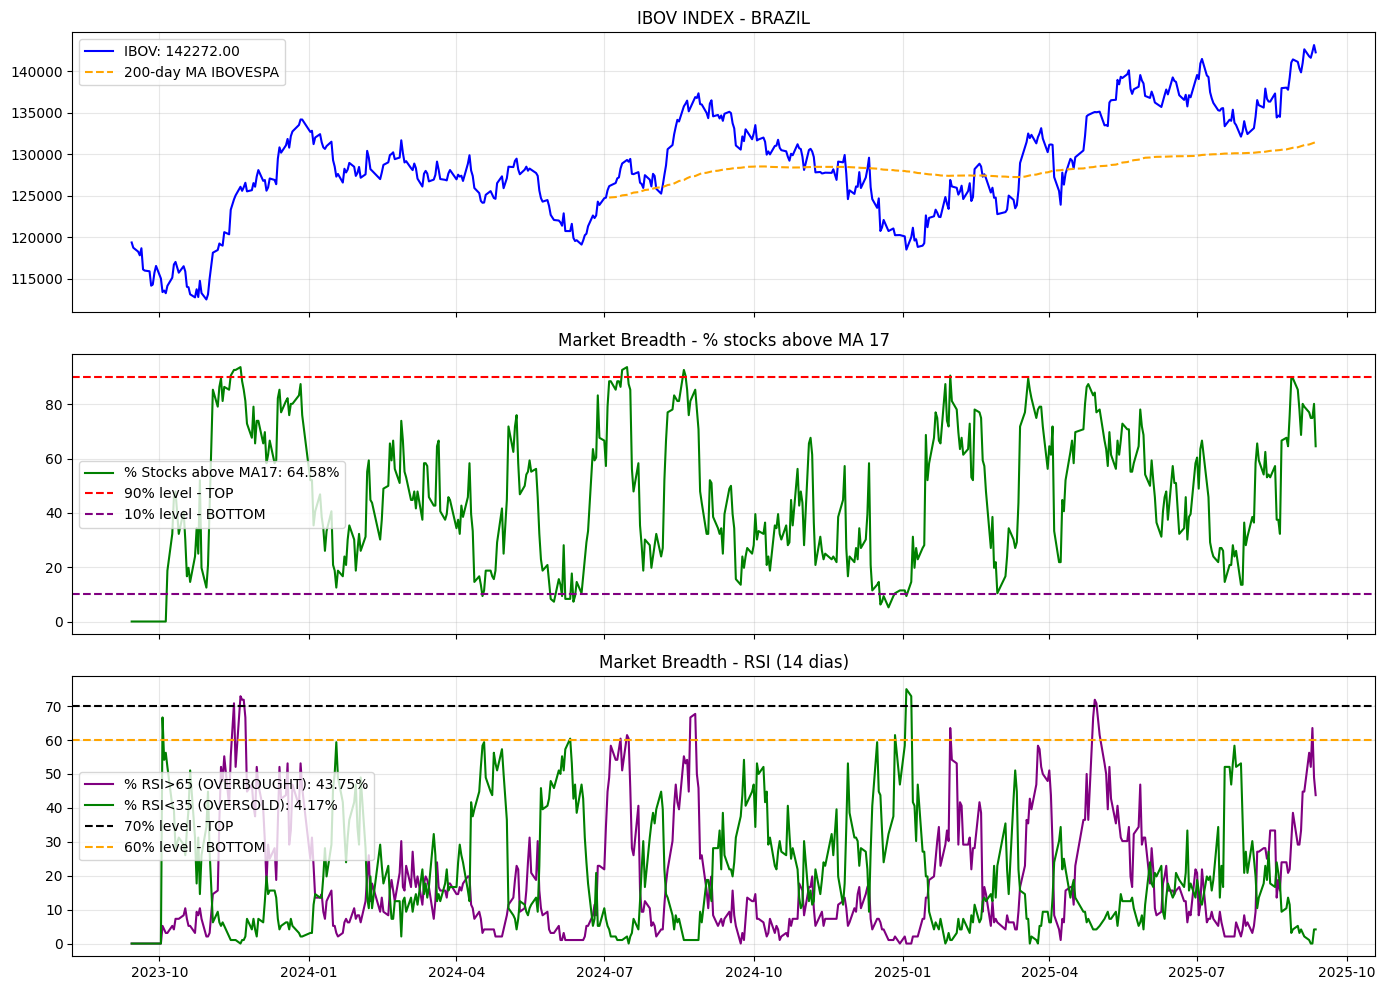

In [60]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# ------------------------------
# Parameters
# ------------------------------
start = (dt.datetime.today() - dt.timedelta(days=730)).strftime("%Y-%m-%d")  # últimos 2 anos
end = dt.datetime.today().strftime("%Y-%m-%d")

moving_avg_days = 17   # média curta
index_symbol = "^BVSP" # IBOVESPA

# Lista IBOVESPA (set/2025)
stocks = [
    "ABEV3.SA","ALOS3.SA","ALPA4.SA","AZZA3.SA","ASAI3.SA","AURE3.SA","AZUL4.SA",
    "B3SA3.SA","BBAS3.SA","BBDC3.SA","BBDC4.SA","BBSE3.SA","BEEF3.SA","BHIA3.SA",
    "BOVA11.SA","BPAC11.SA","BRAP4.SA","BRFS3.SA","BRKM5.SA","CASH3.SA","CBAV3.SA",
    "MOTV3.SA","CMIG4.SA","CMIN3.SA","COGN3.SA","CPFE3.SA","CPLE6.SA","CSAN3.SA",
    "CSMG3.SA","CSNA3.SA","CVCB3.SA","CYRE3.SA","DIRR3.SA","DXCO3.SA","ECOR3.SA",
    "EGIE3.SA","ELET3.SA","ELET6.SA","EMBR3.SA","ENEV3.SA","ENGI11.SA","EQTL3.SA",
    "EZTC3.SA","FLRY3.SA","GGBR4.SA","GMAT3.SA","GOAU4.SA","HAPV3.SA","HYPE3.SA",
    "IGTI11.SA","IRBR3.SA","ITSA4.SA","ITUB4.SA","KLBN11.SA","LREN3.SA","LWSA3.SA",
    "MDIA3.SA","MGLU3.SA","MOVI3.SA","MRFG3.SA","MRVE3.SA","MULT3.SA","PCAR3.SA",
    "PETR3.SA","PETR4.SA","PETZ3.SA","PRIO3.SA","PSSA3.SA","RADL3.SA",
    "RAIL3.SA","RAIZ4.SA","RDOR3.SA","RECV3.SA","RENT3.SA","BRAV3.SA","SANB11.SA",
    "SBSP3.SA","SIMH3.SA","SLCE3.SA","SMAL11.SA","SMTO3.SA","STBP3.SA","SUZB3.SA",
    "TAEE11.SA","TIMS3.SA","TOTS3.SA","ISAE4.SA","UGPA3.SA","USIM5.SA","VALE3.SA",
    "VAMO3.SA","VBBR3.SA","VIVA3.SA","VIVT3.SA","WEGE3.SA","YDUQ3.SA"
]

# ------------------------------
# Download data
# ------------------------------
data = yf.download(stocks, start=start, end=end, auto_adjust=False)["Close"]
index_data = yf.download(index_symbol, start=start, end=end, auto_adjust=False)["Close"]

# ------------------------------
# Market Breadth (MA)
# ------------------------------
mm = data.rolling(window=moving_avg_days).mean()
signals = (data > mm).astype(int)
breadth = signals.mean(axis=1) * 100
index_ma200 = index_data.rolling(window=200).mean()

# ------------------------------
# RSI Function
# ------------------------------
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    gain = pd.Series(gain, index=series.index).rolling(window).mean()
    loss = pd.Series(loss, index=series.index).rolling(window).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# ------------------------------
# RSI Breadth
# ------------------------------
rsi_data = data.apply(compute_rsi, window=14)

# % ativos sobrecomprados (RSI > 65) e sobrevendidos (RSI < 35)
rsi_overbought = (rsi_data > 65).mean(axis=1) * 100
rsi_oversold = (rsi_data < 35).mean(axis=1) * 100

# ------------------------------
# Plotting
# ------------------------------
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# --- IBOVESPA ---
if isinstance(index_data, pd.DataFrame):
    ibov_series = index_data.iloc[:, 0]
else:
    ibov_series = index_data

last_ibov = ibov_series.iloc[-1]
ax1.plot(ibov_series, label=f"IBOV: {last_ibov:.2f}", color="blue")
ax1.plot(index_ma200, label="200-day MA IBOVESPA", color="orange", linestyle="--")
ax1.set_title("IBOV INDEX - BRAZIL")
ax1.legend()
ax1.grid(True, alpha=0.3)

# --- Market Breadth (MA) ---
last_breadth = breadth.iloc[-1]
ax2.plot(breadth, label=f"% Stocks above MA{moving_avg_days}: {last_breadth:.2f}%", color="green")
ax2.axhline(90, color="red", linestyle="--", label="90% level - TOP")
ax2.axhline(10, color="purple", linestyle="--", label="10% level - BOTTOM")
ax2.set_title(f"Market Breadth - % stocks above MA {moving_avg_days}")
ax2.legend(loc='center left')
ax2.grid(True, alpha=0.3)

# --- Market Breadth (RSI) ---
last_overbought = rsi_overbought.iloc[-1]
last_oversold = rsi_oversold.iloc[-1]
ax3.plot(rsi_overbought, label=f"% RSI>65 (OVERBOUGHT): {last_overbought:.2f}%", color="purple")
ax3.plot(rsi_oversold, label=f"% RSI<35 (OVERSOLD): {last_oversold:.2f}%", color="green")
ax3.axhline(70, color="black", linestyle="--", label="70% level - TOP")
ax3.axhline(60, color="orange", linestyle="--", label="60% level - BOTTOM")
ax3.set_title("Market Breadth - RSI (14 dias)")
ax3.legend(loc='center left')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ------------------------------
# Lista para armazenar os resultados
# ------------------------------
summary = []

last_date = ibov_series.index[-1].strftime("%Y-%m-%d")  # data do último valor
last_value = ibov_series.iloc[-1]                        # valor do último índice
summary.append({
    "Index": "IBOV",
    "Last Date": last_date,
    "Last Value": last_value,
    "% Above MA": breadth.iloc[-1],
    "% RSI > 65": rsi_overbought.iloc[-1],
    "% RSI < 35": rsi_oversold.iloc[-1]
})



The next step in this project is to extend the analysis to the ***S&P 500***, the most influential stock market index worldwide. Given its central role in the global economy, movements in the U.S. market often ***ripple*** across international markets, making it a crucial reference point for any breadth analysis.

[*********************100%***********************]  499 of 499 completed
[*********************100%***********************]  1 of 1 completed


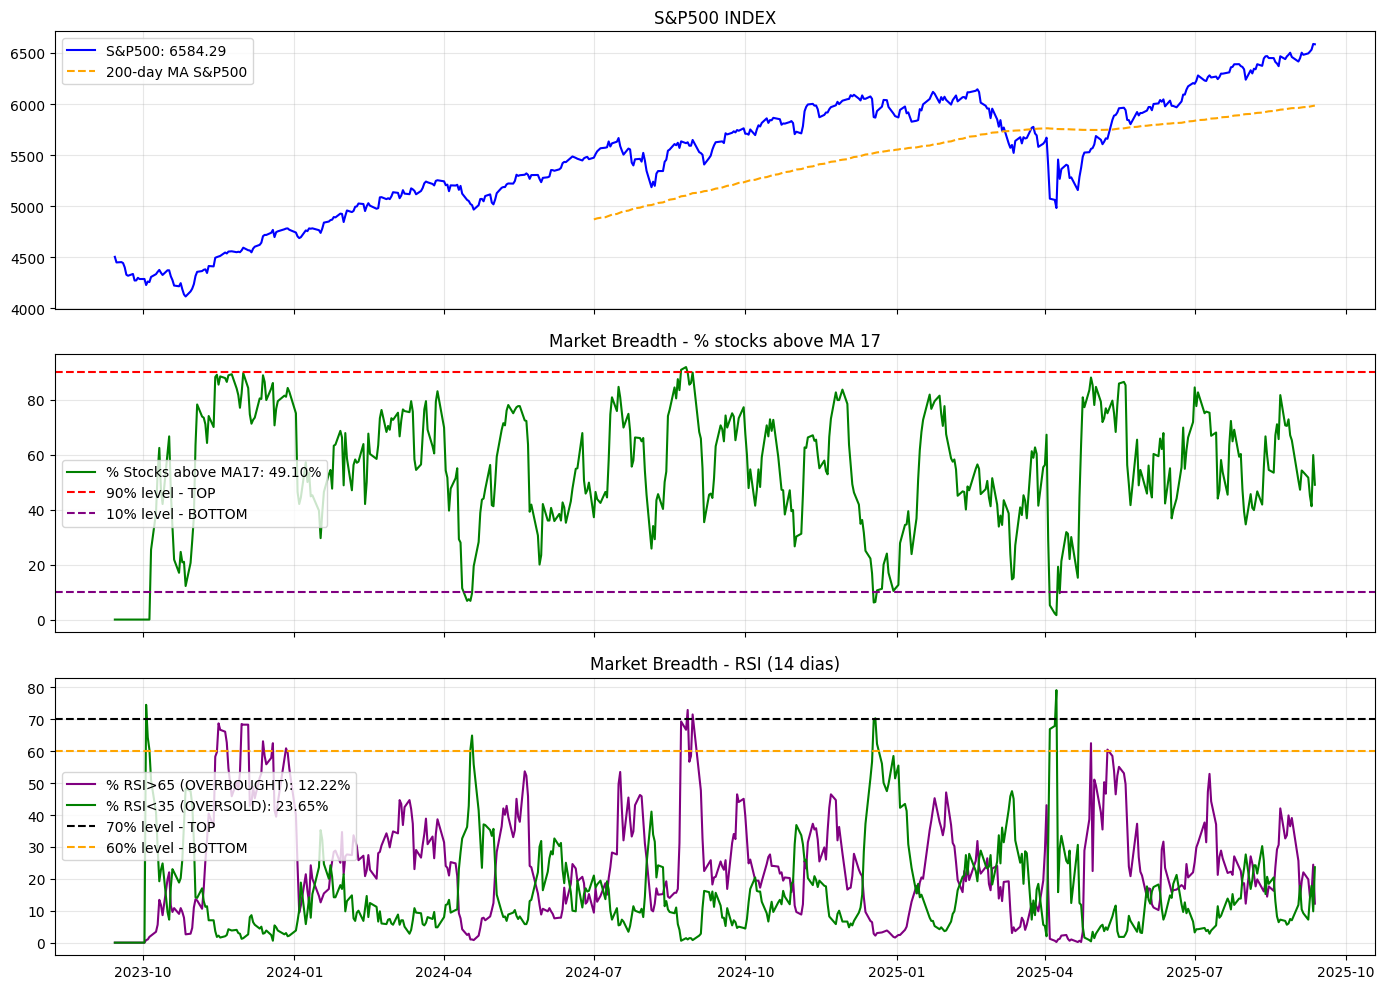

In [61]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# ------------------------------
# Parameters
# ------------------------------
start = (dt.datetime.today() - dt.timedelta(days=730)).strftime("%Y-%m-%d")  # últimos 2 anos
end = dt.datetime.today().strftime("%Y-%m-%d")

moving_avg_days = 17    # média curta
index_symbol = "^GSPC"  # S&P500

# ------------------------------
# Lista de Ações do S&P500
# ------------------------------
# (Lista resumida para exemplo – você pode expandir com todos os 500 tickers)
stocks = [
    "AAPL","MSFT","NVDA","AMZN","META","GOOGL","GOOG","BRK-B","LLY","AVGO",
    "TSLA","JPM","UNH","XOM","V","PG","JNJ","MA","COST","HD","ABBV","WMT",
    "MRK","NFLX","BAC","KO","CVX","CRM","ADBE","PEP","TMO","ORCL","LIN","AMD",
    "ACN","WFC","MCD","CSCO","ABT","GE","DHR","QCOM","PM","AMGN","INTU","TXN",
    "IBM","PFE","VZ","DIS","NOW","AMAT","CAT","GS","NEE","ISRG","CMCSA","SPGI",
    "RTX","UNP","AXP","T","LOW","HON","VRTX","TJX","MS","UBER","COP","PGR",
    "BKNG","ELV","INTC","BLK","C","ETN","PLD","LMT","REGN","SYK","MU","MMC",
    "CB","BSX","ADI","LRCX","MDT","ADP","AMT","BA","PANW","KLAC","BMY","BX",
    "TMUS","SO","GILD","SCHW","UPS","CI","FI","DE","MDLZ","NKE","DUK","ICE",
    "MO","ANET","SBUX","CL","ZTS","SNPS","MCK","SHW","KKR","EQIX","CVS","WM",
    "TT","APH","CMG","MCO","AON","CDNS","EOG","CME","HCA","TDG","PNC","MMM",
    "PH","NOC","BDX","PYPL","CSX","TGT","USB","FDX","WELL","ORLY","SLB","GD",
    "MSI","ITW","CTAS","EMR","APD","FCX","NXPI","AJG","MPC","ECL","PSX","ABNB",
    "ROP","TFC","NEM","CEG","NSC","CARR","COF","AZO","DHI","AEP","AFL","WMB",
    "MAR","CRWD","ADSK","HLT","SRE","VLO","O","PCAR","SPG","AIG","GM","DLR",
    "CCI","TRV","BK","ROST","URI","OKE","PSA","GEV","KMB","JCI","ALL","D","TEL",
    "MCHP","IQV","CPRT","MET","PRU","LEN","LHX","MSCI","HUM","AMP","A","FIS",
    "F","CMI","CNC","GWW","KMI","PAYX","COR","RSG","PEG","IDXX","STZ","PCG",
    "OXY","FICO","HES","FAST","GIS","IT","OTIS","CTSH","EXC","BKR","YUM","SYY",
    "MPWR","EW","DOW","NUE","CTVA","VRSK","CHTR","HWM","PWR","IR","AME","FTNT",
    "MNST","ODFL","EA","MLM","KR","ACGL","VMC","KDP","KVUE","FANG","GEHC","RCL",
    "EFX","ED","DD","SMCI","EXR","CBRE","HIG","MTD","XEL","VICI","IRM","XYL",
    "RMD","CSGP","EIX","MRNA","ON","GLW","HPQ","BIIB","ROK","TRGP","AVB","ADM",
    "HAL","PPG","WTW","DVN","HSY","LULU","CDW","EBAY","KHC","AWK","WEC","DXCM",
    "NDAQ","FITB","MTB","TSCO","PHM","NVR","WAB","ANSS","DAL","DG","GRMN","ETR",
    "DTE","NTAP","BR","CAH","IFF","STT","DOV","GPN","TROW","LYB","VST","FTV",
    "SBAC","CHD","HPE","EQR","STE","TYL","BRO","VLTO","FSLR","WY","DECK","ZBH",
    "KEYS","ES","TTWO","EL","WST","PPL","VTR","FE","SW","AXON","RJF","AEE","PTC",
    "WAT","DLTR","HBAN","INVH","CINF","HUBB","BALL","MOH","GPC","CPAY","RF",
    "GDDY","APTV","SYF","EQT","LH","LDOS","TDY","BLDR","MKC","CBOE","HOLX","WDC",
    "ATO","CMS","STX","CTRA","CFG","OMC","STLD","COO","TER","WBD","ESS","J","BAX",
    "NTRS","ARE","EXPD","CNP","PKG","TXT","ZBRA","DRI","PFG","TSN","AVY","SWKS",
    "ULTA","MAA","WRB","VRSN","MAS","CLX","BBY","DGX","K","ALGN","IP","EG","CCL",
    "LUV","SWK","FDS","RVTY","EXPE","DOC","NRG","AMCR","ENPH","BG","DPZ","IEX",
    "SNA","KIM","L","AKAM","CAG","VTRS","LNT","KEY","NI","GEN","LVS","POOL","PNR",
    "UAL","CF","PODD","EVRG","JBHT","CE","ROL","LYV","JBL","UHS","NDSN","TRMB",
    "TECH","KMX","CRL","UDR","JKHY","EPAM","SJM","CPT","EMN","AES","CHRW",
    "IPG","HST","ALLE","FFIV","REG","APA","TFX","ALB","QRVO","LKQ","HII","NWSA",
    "MTCH","AOS","BXP","PNW","TAP","HSIC","INCY","CPB","MOS","HRL","MGM","FOXA",
    "AIZ","TPR","GNRC","DAY","WBA","LW","MKTX","HAS","FRT","PAYC","BF-B","FMC",
    "MHK","SOLV","BBWI","GL","CZR","BWA","IVZ","WYNN","DVA","NCLH","ETSY","BIO",
    "RL","AAL","BEN","PARA","FOX","NWS"
]

# ------------------------------
# Download data
# ------------------------------
data = yf.download(stocks, start=start, end=end, auto_adjust=False)["Close"]
index_data = yf.download(index_symbol, start=start, end=end, auto_adjust=False)["Close"]

# ------------------------------
# Market Breadth (MA)
# ------------------------------
mm = data.rolling(window=moving_avg_days).mean()
signals = (data > mm).astype(int)
breadth = signals.mean(axis=1) * 100
index_ma200 = index_data.rolling(window=200).mean()

# ------------------------------
# RSI Function
# ------------------------------
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    gain = pd.Series(gain, index=series.index).rolling(window).mean()
    loss = pd.Series(loss, index=series.index).rolling(window).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# ------------------------------
# RSI Breadth
# ------------------------------
rsi_data = data.apply(compute_rsi, window=14)

# % ativos sobrecomprados (RSI > 65) e sobrevendidos (RSI < 35)
rsi_overbought = (rsi_data > 65).mean(axis=1) * 100
rsi_oversold = (rsi_data < 35).mean(axis=1) * 100

# ------------------------------
# Plotting
# ------------------------------
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# --- S&P500 ---
if isinstance(index_data, pd.DataFrame):
    sp500_series = index_data.iloc[:, 0]
else:
    sp500_series = index_data

last_sp500 = sp500_series.iloc[-1]
ax1.plot(sp500_series, label=f"S&P500: {last_sp500:.2f}", color="blue")
ax1.plot(index_ma200, label="200-day MA S&P500", color="orange", linestyle="--")
ax1.set_title("S&P500 INDEX")
ax1.legend()
ax1.grid(True, alpha=0.3)

# --- Market Breadth (MA) ---
last_breadth = breadth.iloc[-1]
ax2.plot(breadth, label=f"% Stocks above MA{moving_avg_days}: {last_breadth:.2f}%", color="green")
ax2.axhline(90, color="red", linestyle="--", label="90% level - TOP")
ax2.axhline(10, color="purple", linestyle="--", label="10% level - BOTTOM")
ax2.set_title(f"Market Breadth - % stocks above MA {moving_avg_days}")
ax2.legend(loc='center left')
ax2.grid(True, alpha=0.3)

# --- Market Breadth (RSI) ---
last_overbought = rsi_overbought.iloc[-1]
last_oversold = rsi_oversold.iloc[-1]
ax3.plot(rsi_overbought, label=f"% RSI>65 (OVERBOUGHT): {last_overbought:.2f}%", color="purple")
ax3.plot(rsi_oversold, label=f"% RSI<35 (OVERSOLD): {last_oversold:.2f}%", color="green")
ax3.axhline(70, color="black", linestyle="--", label="70% level - TOP")
ax3.axhline(60, color="orange", linestyle="--", label="60% level - BOTTOM")
ax3.set_title("Market Breadth - RSI (14 dias)")
ax3.legend(loc='center left')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ------------------------------
# Lista para armazenar os resultados
# ------------------------------

last_date = ibov_series.index[-1].strftime("%Y-%m-%d")  # data do último valor
last_value = ibov_series.iloc[-1]                        # valor do último índice
summary.append({
    "Index": "SP&500",
    "Last Date": last_date,
    "Last Value": last_sp500,
    "% Above MA": breadth.iloc[-1],
    "% RSI > 65": rsi_overbought.iloc[-1],
    "% RSI < 35": rsi_oversold.iloc[-1]
})



The 3rd part of the experiement is to analyse the DAX from germany the main engine of Europe economy to corelate the world market sentiment in a given moment

[*********************100%***********************]  40 of 40 completed
[*********************100%***********************]  1 of 1 completed


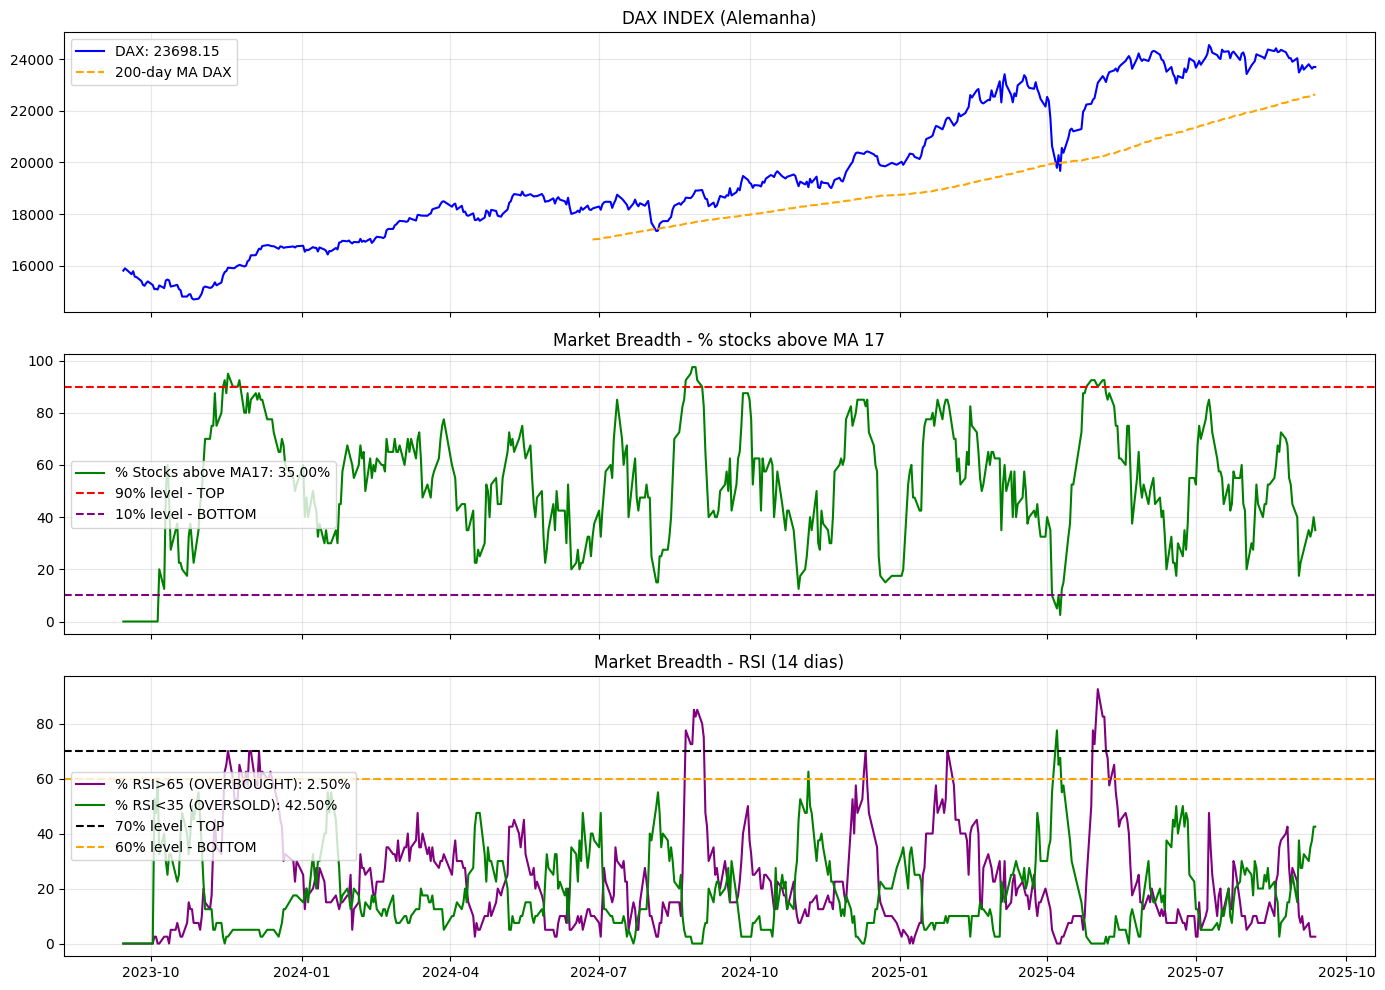

In [62]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# ------------------------------
# Parameters
# ------------------------------
start = (dt.datetime.today() - dt.timedelta(days=730)).strftime("%Y-%m-%d")  # últimos 2 anos
end = dt.datetime.today().strftime("%Y-%m-%d")

moving_avg_days = 17    # média curta
index_symbol = "^GDAXI" # DAX 40

# ------------------------------
# Lista de ações do DAX40
# ------------------------------
stocks = [
    "ADS.DE","ALV.DE","BAS.DE","BAYN.DE","BMW.DE","CON.DE","1COV.DE","DHER.DE","DBK.DE","DTE.DE",
    "EOAN.DE","FME.DE","FRE.DE","HEI.DE","HEN3.DE","IFX.DE","LIN.DE","MRK.DE","MTX.DE","MUV2.DE",
    "PUM.DE","QIA.DE","RWE.DE","SAP.DE","SIE.DE","SHL.DE","SRT3.DE","SY1.DE","VNA.DE","VOW3.DE",
    "ZAL.DE","MBG.DE","BNR.DE","HNR1.DE","ENR.DE","BEI.DE","RHM.DE","DWNI.DE","PAH3.DE","HFG.DE"
]

# ------------------------------
# Download data
# ------------------------------
data = yf.download(stocks, start=start, end=end, auto_adjust=False)["Close"]
index_data = yf.download(index_symbol, start=start, end=end, auto_adjust=False)["Close"]

# ------------------------------
# Market Breadth (MA)
# ------------------------------
mm = data.rolling(window=moving_avg_days).mean()
signals = (data > mm).astype(int)
breadth = signals.mean(axis=1) * 100
index_ma200 = index_data.rolling(window=200).mean()

# ------------------------------
# RSI Function
# ------------------------------
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    gain = pd.Series(gain, index=series.index).rolling(window).mean()
    loss = pd.Series(loss, index=series.index).rolling(window).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# ------------------------------
# RSI Breadth
# ------------------------------
rsi_data = data.apply(compute_rsi, window=14)

# % ativos sobrecomprados (RSI > 65) e sobrevendidos (RSI < 35)
rsi_overbought = (rsi_data > 65).mean(axis=1) * 100
rsi_oversold = (rsi_data < 35).mean(axis=1) * 100

# ------------------------------
# Plotting
# ------------------------------
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# --- DAX ---
if isinstance(index_data, pd.DataFrame):
    dax_series = index_data.iloc[:, 0]
else:
    dax_series = index_data

last_dax = dax_series.iloc[-1]
ax1.plot(dax_series, label=f"DAX: {last_dax:.2f}", color="blue")
ax1.plot(index_ma200, label="200-day MA DAX", color="orange", linestyle="--")
ax1.set_title("DAX INDEX (Alemanha)")
ax1.legend()
ax1.grid(True, alpha=0.3)

# --- Market Breadth (MA) ---
last_breadth = breadth.iloc[-1]
ax2.plot(breadth, label=f"% Stocks above MA{moving_avg_days}: {last_breadth:.2f}%", color="green")
ax2.axhline(90, color="red", linestyle="--", label="90% level - TOP")
ax2.axhline(10, color="purple", linestyle="--", label="10% level - BOTTOM")
ax2.set_title(f"Market Breadth - % stocks above MA {moving_avg_days}")
ax2.legend(loc='center left')
ax2.grid(True, alpha=0.3)

# --- Market Breadth (RSI) ---
last_overbought = rsi_overbought.iloc[-1]
last_oversold = rsi_oversold.iloc[-1]
ax3.plot(rsi_overbought, label=f"% RSI>65 (OVERBOUGHT): {last_overbought:.2f}%", color="purple")
ax3.plot(rsi_oversold, label=f"% RSI<35 (OVERSOLD): {last_oversold:.2f}%", color="green")
ax3.axhline(70, color="black", linestyle="--", label="70% level - TOP")
ax3.axhline(60, color="orange", linestyle="--", label="60% level - BOTTOM")
ax3.set_title("Market Breadth - RSI (14 dias)")
ax3.legend(loc='center left')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ------------------------------
# Lista para armazenar os resultados
# ------------------------------

last_date = ibov_series.index[-1].strftime("%Y-%m-%d")  # data do último valor
last_value = ibov_series.iloc[-1]                        # valor do último índice
summary.append({
    "Index": "DAX",
    "Last Date": last_date,
    "Last Value": last_dax,
    "% Above MA": breadth.iloc[-1],
    "% RSI > 65": rsi_overbought.iloc[-1],
    "% RSI < 35": rsi_oversold.iloc[-1]
})



For the 4th experiment let us get someone to represent Asia like the HSI  o Hang Seng Index from Hong Kong . We are taking here 50 main stochs

[*********************100%***********************]  50 of 50 completed
[*********************100%***********************]  1 of 1 completed


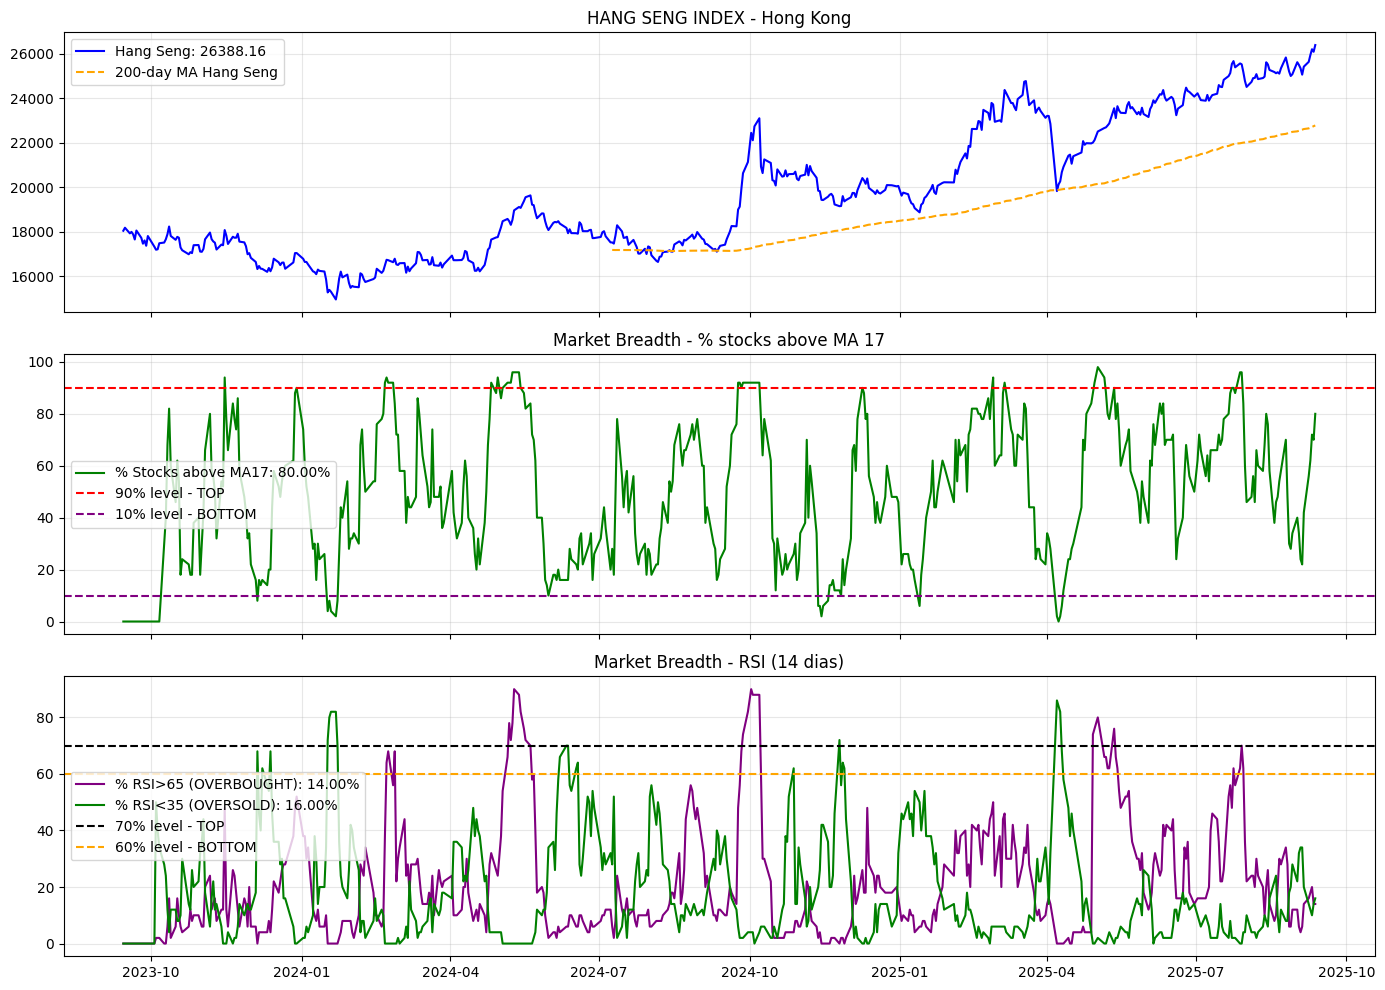

In [63]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# ------------------------------
# Parameters
# ------------------------------
start = (dt.datetime.today() - dt.timedelta(days=730)).strftime("%Y-%m-%d")  # últimos 2 anos
end = dt.datetime.today().strftime("%Y-%m-%d")

moving_avg_days = 17    # média curta
index_symbol = "^HSI"   # Hang Seng Index (Hong Kong)

# ------------------------------
# Lista de ações do Hang Seng (HSI 50)
# ------------------------------
stocks = [
    "0001.HK","0002.HK","0003.HK","0005.HK","0006.HK","0011.HK","0012.HK","0016.HK",
    "0017.HK","0019.HK","0066.HK","0101.HK","0175.HK","0267.HK","0288.HK","0291.HK",
    "0386.HK","0388.HK","0669.HK","0700.HK","0762.HK","0823.HK","0836.HK","0857.HK",
    "0868.HK","0883.HK","0960.HK","0968.HK","0981.HK","1038.HK","1044.HK","1093.HK",
    "1109.HK","1113.HK","1299.HK","1398.HK","1928.HK","2007.HK","2018.HK","2020.HK",
    "2269.HK","2313.HK","2318.HK","2319.HK","2382.HK","2388.HK","2628.HK","2688.HK",
    "3690.HK","3968.HK"
]

# ------------------------------
# Download data
# ------------------------------
data = yf.download(stocks, start=start, end=end, auto_adjust=False)["Close"]
index_data = yf.download(index_symbol, start=start, end=end, auto_adjust=False)["Close"]

# ------------------------------
# Market Breadth (MA)
# ------------------------------
mm = data.rolling(window=moving_avg_days).mean()
signals = (data > mm).astype(int)
breadth = signals.mean(axis=1) * 100
index_ma200 = index_data.rolling(window=200).mean()

# ------------------------------
# RSI Function
# ------------------------------
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    gain = pd.Series(gain, index=series.index).rolling(window).mean()
    loss = pd.Series(loss, index=series.index).rolling(window).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# ------------------------------
# RSI Breadth
# ------------------------------
rsi_data = data.apply(compute_rsi, window=14)

# % ativos sobrecomprados (RSI > 65) e sobrevendidos (RSI < 35)
rsi_overbought = (rsi_data > 65).mean(axis=1) * 100
rsi_oversold = (rsi_data < 35).mean(axis=1) * 100

# ------------------------------
# Plotting
# ------------------------------
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# --- HANG SENG ---
if isinstance(index_data, pd.DataFrame):
    hsi_series = index_data.iloc[:, 0]
else:
    hsi_series = index_data

last_hsi = hsi_series.iloc[-1]
ax1.plot(hsi_series, label=f"Hang Seng: {last_hsi:.2f}", color="blue")
ax1.plot(index_ma200, label="200-day MA Hang Seng", color="orange", linestyle="--")
ax1.set_title("HANG SENG INDEX - Hong Kong")
ax1.legend()
ax1.grid(True, alpha=0.3)

# --- Market Breadth (MA) ---
last_breadth = breadth.iloc[-1]
ax2.plot(breadth, label=f"% Stocks above MA{moving_avg_days}: {last_breadth:.2f}%", color="green")
ax2.axhline(90, color="red", linestyle="--", label="90% level - TOP")
ax2.axhline(10, color="purple", linestyle="--", label="10% level - BOTTOM")
ax2.set_title(f"Market Breadth - % stocks above MA {moving_avg_days}")
ax2.legend(loc='center left')
ax2.grid(True, alpha=0.3)

# --- Market Breadth (RSI) ---
last_overbought = rsi_overbought.iloc[-1]
last_oversold = rsi_oversold.iloc[-1]
ax3.plot(rsi_overbought, label=f"% RSI>65 (OVERBOUGHT): {last_overbought:.2f}%", color="purple")
ax3.plot(rsi_oversold, label=f"% RSI<35 (OVERSOLD): {last_oversold:.2f}%", color="green")
ax3.axhline(70, color="black", linestyle="--", label="70% level - TOP")
ax3.axhline(60, color="orange", linestyle="--", label="60% level - BOTTOM")
ax3.set_title("Market Breadth - RSI (14 dias)")
ax3.legend(loc='center left')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ------------------------------
# Lista para armazenar os resultados
# ------------------------------

last_date = ibov_series.index[-1].strftime("%Y-%m-%d")  # data do último valor
last_value = ibov_series.iloc[-1]                        # valor do último índice
summary.append({
    "Index": "Hang Seng",
    "Last Date": last_date,
    "Last Value": last_hsi,
    "% Above MA": breadth.iloc[-1],
    "% RSI > 65": rsi_overbought.iloc[-1],
    "% RSI < 35": rsi_oversold.iloc[-1]
})


For a complementay view let us take a look also on the Shanghai Composites

[*********************100%***********************]  13 of 13 completed
[*********************100%***********************]  1 of 1 completed


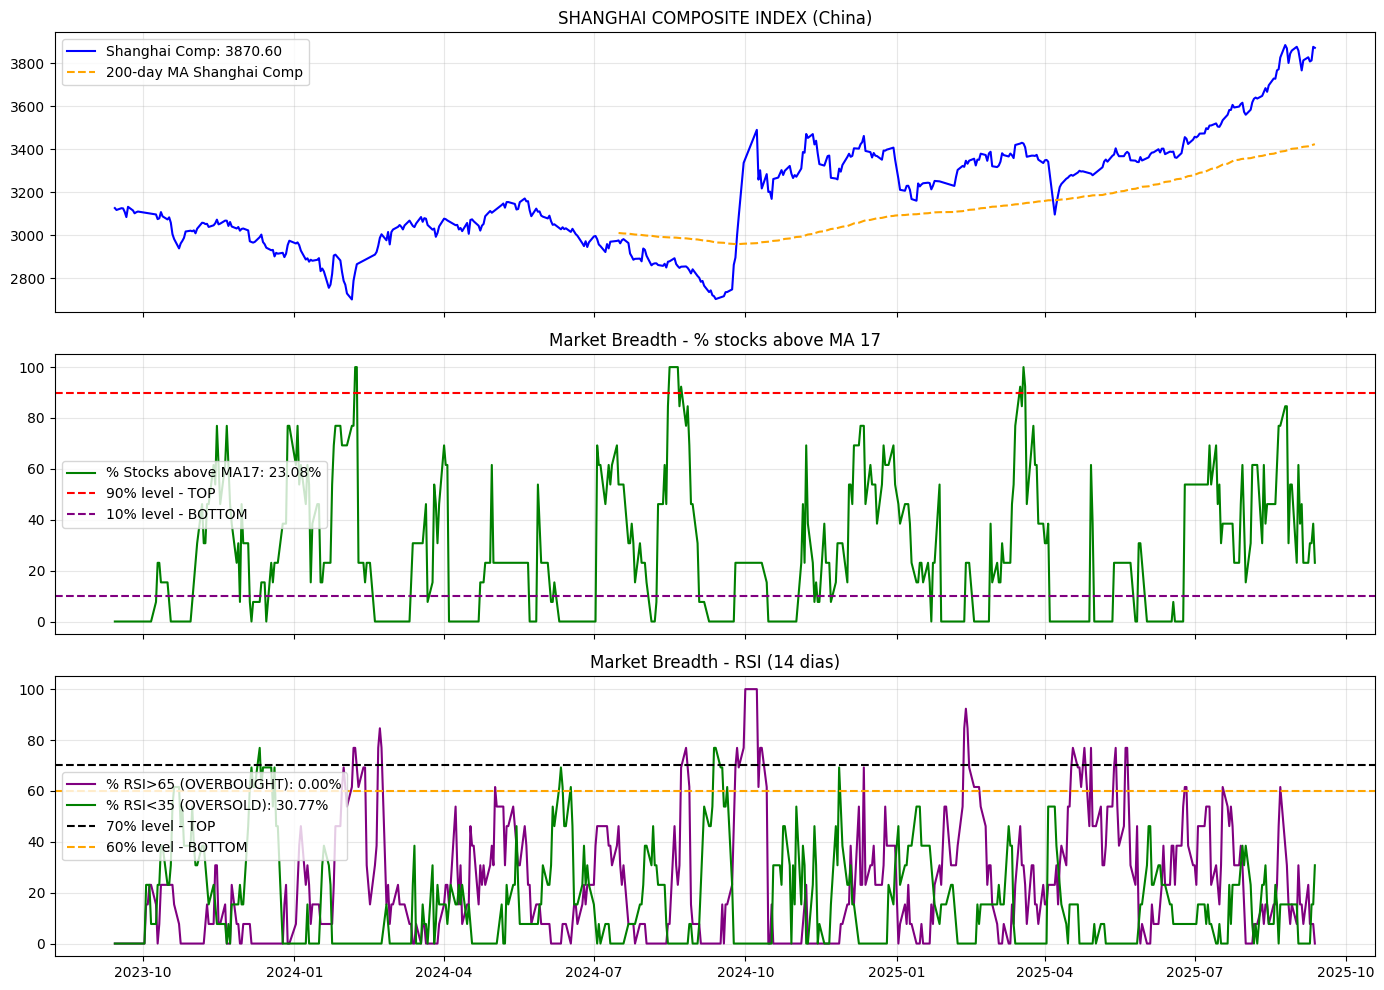

In [64]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# ------------------------------
# Parameters
# ------------------------------
start = (dt.datetime.today() - dt.timedelta(days=730)).strftime("%Y-%m-%d")  # últimos 2 anos
end = dt.datetime.today().strftime("%Y-%m-%d")

moving_avg_days = 17
index_symbol = "000001.SS"   # Shanghai Composite Index

# ------------------------------
# Lista de ações (exemplo: CSI 300 - top empresas da China)
# Obs: Para simplificar, aqui vai uma amostra (não todos os 300 tickers)
# Você pode expandir a lista depois.
stocks = [
     "600000.SS",  # Shanghai Pudong Dev Bank
    "600028.SS",  # China Petroleum & Chemical
    "600519.SS",  # Kweichow Moutai (beverages giant)
    "600036.SS",  # China Merchants Bank
    "601318.SS",  # Ping An Insurance
    "601668.SS",  # China State Construction
    "601857.SS",  # PetroChina
    "601988.SS",  # Bank of China
    "601939.SS",  # China Construction Bank
    "601288.SS",  # Agricultural Bank of China
    # ETFs as proxies for broader market
    "ASHR",       # CSI 300 ETF (US)
    "MCHI",       # MSCI China ETF (US)
    "FXI"         # China Large Cap ETF (US)
]

# ------------------------------
# Download data
# ------------------------------
data = yf.download(stocks, start=start, end=end, auto_adjust=False)["Close"]
index_data = yf.download(index_symbol, start=start, end=end, auto_adjust=False)["Close"]

# ------------------------------
# Market Breadth (MA)
# ------------------------------
mm = data.rolling(window=moving_avg_days).mean()
signals = (data > mm).astype(int)
breadth = signals.mean(axis=1) * 100
index_ma200 = index_data.rolling(window=200).mean()

# ------------------------------
# RSI Function
# ------------------------------
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    gain = pd.Series(gain, index=series.index).rolling(window).mean()
    loss = pd.Series(loss, index=series.index).rolling(window).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# ------------------------------
# RSI Breadth
# ------------------------------
rsi_data = data.apply(compute_rsi, window=14)

rsi_overbought = (rsi_data > 65).mean(axis=1) * 100
rsi_oversold = (rsi_data < 35).mean(axis=1) * 100

# ------------------------------
# Plotting
# ------------------------------
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# --- SHANGHAI COMPOSITE ---
if isinstance(index_data, pd.DataFrame):
    shcomp_series = index_data.iloc[:, 0]
else:
    shcomp_series = index_data

last_shcomp = shcomp_series.iloc[-1]
ax1.plot(shcomp_series, label=f"Shanghai Comp: {last_shcomp:.2f}", color="blue")
ax1.plot(index_ma200, label="200-day MA Shanghai Comp", color="orange", linestyle="--")
ax1.set_title("SHANGHAI COMPOSITE INDEX (China)")
ax1.legend()
ax1.grid(True, alpha=0.3)

# --- Market Breadth (MA) ---
last_breadth = breadth.iloc[-1]
ax2.plot(breadth, label=f"% Stocks above MA{moving_avg_days}: {last_breadth:.2f}%", color="green")
ax2.axhline(90, color="red", linestyle="--", label="90% level - TOP")
ax2.axhline(10, color="purple", linestyle="--", label="10% level - BOTTOM")
ax2.set_title(f"Market Breadth - % stocks above MA {moving_avg_days}")
ax2.legend(loc='center left')
ax2.grid(True, alpha=0.3)

# --- Market Breadth (RSI) ---
last_overbought = rsi_overbought.iloc[-1]
last_oversold = rsi_oversold.iloc[-1]
ax3.plot(rsi_overbought, label=f"% RSI>65 (OVERBOUGHT): {last_overbought:.2f}%", color="purple")
ax3.plot(rsi_oversold, label=f"% RSI<35 (OVERSOLD): {last_oversold:.2f}%", color="green")
ax3.axhline(70, color="black", linestyle="--", label="70% level - TOP")
ax3.axhline(60, color="orange", linestyle="--", label="60% level - BOTTOM")
ax3.set_title("Market Breadth - RSI (14 dias)")
ax3.legend(loc='center left')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ------------------------------
# Lista para armazenar os resultados
# ------------------------------

last_date = ibov_series.index[-1].strftime("%Y-%m-%d")  # data do último valor
last_value = ibov_series.iloc[-1]                        # valor do último índice
summary.append({
    "Index": "Shanghai Composites",
    "Last Date": last_date,
    "Last Value": last_shcomp,
    "% Above MA": breadth.iloc[-1],
    "% RSI > 65": rsi_overbought.iloc[-1],
    "% RSI < 35": rsi_oversold.iloc[-1]
})



In [66]:
# ------------------------------
# Criar DataFrame e exibir tabela
# ------------------------------
summary_df = pd.DataFrame(summary)
display(summary_df.round(2))

,Index,Last Date,Last Value,% Above MA,% RSI > 65,% RSI < 35
0,IBOV,2025-09-12,142272.00,64.58,43.75,4.17
1,SP&500,2025-09-12,6584.29,49.10,12.22,23.65
2,DAX,2025-09-12,23698.15,35.00,2.50,42.50
3,Hang Seng,2025-09-12,26388.16,80.00,14.00,16.00
4,Shanghai Composites,2025-09-12,3870.60,23.08,0.00,30.77


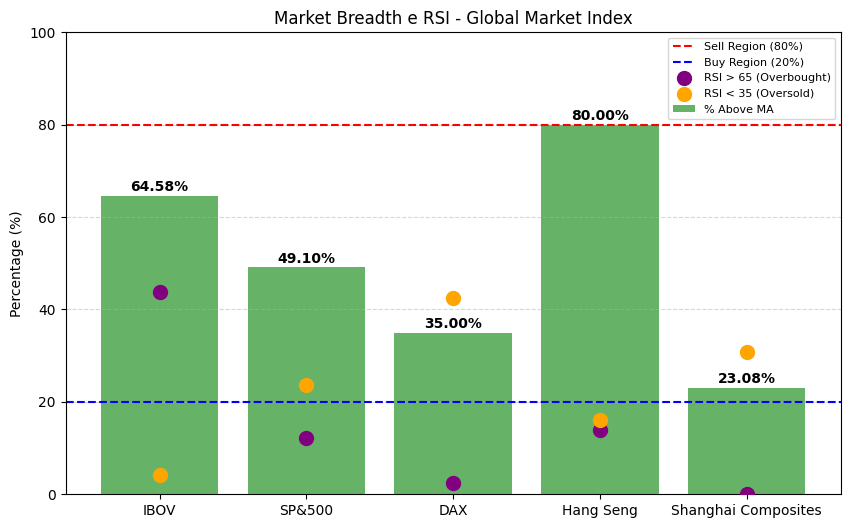

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# --- Barras % Above MA ---
plt.bar(summary_df["Index"], summary_df["% Above MA"], color="green", alpha=0.6, label="% Above MA")

# --- Linha horizontal para sinais ---
plt.axhline(80, color="red", linestyle="--", linewidth=1.5, label="Sell Region (80%)")
plt.axhline(20, color="blue", linestyle="--", linewidth=1.5, label="Buy Region (20%)")

# --- Pontos RSI ---
plt.scatter(summary_df["Index"], summary_df["% RSI > 65"], color="purple", s=100, label="RSI > 65 (Overbought)", zorder=5)
plt.scatter(summary_df["Index"], summary_df["% RSI < 35"], color="orange", s=100, label="RSI < 35 (Oversold)", zorder=5)

# --- Eixos e título ---
plt.ylim(0, 100)
plt.ylabel("Percentage (%)")
plt.title("Market Breadth e RSI - Global Market Index")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(loc="upper right", fontsize=8)

# --- Valores em cima das barras ---
for i, v in enumerate(summary_df["% Above MA"]):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', fontweight='bold')

plt.show()
